In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))
print(sys.path)

# load test dataset
from torch.utils.data import DataLoader
import json

import json
from tqdm import tqdm
import numpy as np
import os
import argparse

import torch
from torch import nn, optim
from torchvision import transforms as T
import json

from tasks.seq_mnist import SeqMNISTModelTraining_ntm, SeqMNISTParams_ntm, SeqMNISTModelTraining_lstm
import json
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

['/Users/kerekmen/miniconda3/envs/s4/lib/python312.zip', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12/lib-dynload', '', '/Users/kerekmen/miniconda3/envs/s4/lib/python3.12/site-packages', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar', '/Users/kerekmen/Studium/Master/Semester2/NN/nn-seminar']


## Plot losses

Sequence Length: 64


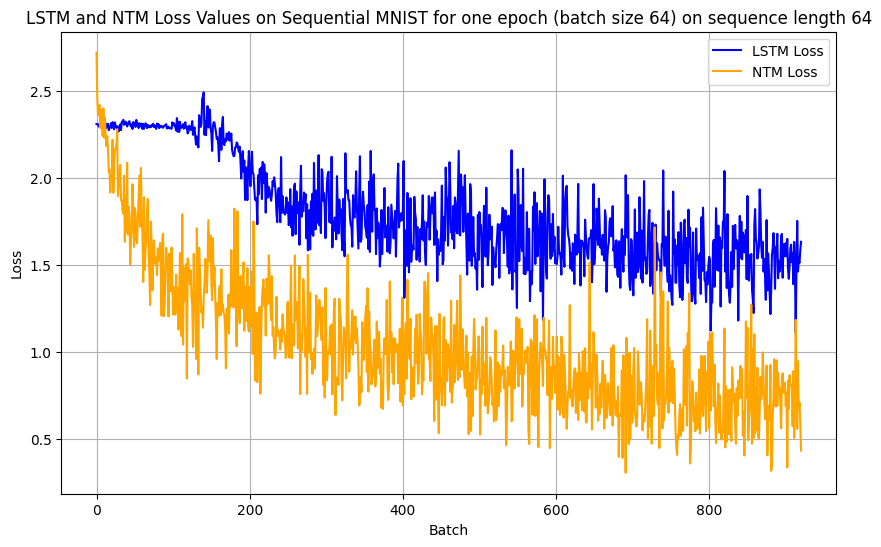

In [7]:
lstm_path_json = '../checkpoints/seq-mnist-lstm-seq-mnist-ntm-seed-1000-epoch-1-batch-920-2024-06-1111-36-07.json'
ntm_path_json = '../checkpoints/seq-mnist-ntm-cache-seq-mnist-ntm-cache-seed-1000-epoch-1-batch-920-2024-06-1111-32-39.json'

lstm_path_pt = os.path.splitext(lstm_path_json)[0] + '.pth'
ntm_path_pt = os.path.splitext(ntm_path_json)[0] + '.pth'


# Load the loss data from the JSON file
with open(lstm_path_json) as f:
    data_lstm = json.load(f)

with open(ntm_path_json) as f:
    data_ntm = json.load(f)

loss_lstm = data_lstm['loss']
loss_ntm = data_ntm['loss']

# Check if the important parameters are the same
# assert data_lstm["parameters_model"]["resize_resolution"] == data_ntm["parameters_model"]["resize_resolution"]
# assert data_lstm["parameters_model"]["memory_m"] == data_ntm["parameters_model"]["memory_m"]
# assert data_lstm["parameters_model"]["memory_n"] == data_ntm["parameters_model"]["memory_n"]

resolution = data_lstm["parameters_model"]["resize_resolution"]
sequence_len = resolution**2
print(f"Sequence Length: {sequence_len}")

# Define the window size for the rolling average
window_size = 400

# Adjust x to match the length of loss_avg
x_lstm = np.arange(len(loss_lstm))
x_ntm = np.arange(len(loss_ntm))

# plot both lstm and ntm losses on squential mnist
plt.figure(figsize=(10, 6))
plt.plot(x_lstm, loss_lstm, label='LSTM Loss', color='blue')
plt.plot(x_ntm, loss_ntm, label='NTM Loss', color='orange')
plt.title(f'LSTM and NTM Loss Values on Sequential MNIST for one epoch (batch size 64) on sequence length {sequence_len}')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# load test dataset
task_params = {
    "resize_resolution": resolution,
}
test_dataset = SequentialMNIST(task_params, train=False)

# load the model
lstm = SeqMNISTModelTraining_lstm()
ntm = SeqMNISTModelTraining_ntm()
lstm.net.load_state_dict(torch.load(lstm_path_pt))
ntm.net.load_state_dict(torch.load(ntm_path_pt))

<All keys matched successfully>

# Run evaluation

In [9]:
from tqdm import tqdm

print(f"Number of samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False, )

dict_model = {
    "LSTM": lstm,
    "NTM": ntm
}

for model_name in dict_model:
    print(f"Testing model: {model_name}")
    model = dict_model[model_name]
    model.net.eval()
    correct = 0
    total = 0
    for i, (X, Y) in enumerate(tqdm(test_loader)):
        X = X.permute(1, 0, 2)
        Y = Y.squeeze(1)
        
        batch_size = X.size(1)
        if model_name == "NTM":
            model.net.init_sequence(batch_size)

        # Forward pass
        if model_name == "LSTM":
            y_out = model.net(X)
        else:
            for j in range(X.size(0)):
                y_out, _ = model.net(X[j])
        
        _, predicted = torch.max(y_out.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

Number of samples: 10000
Testing model: LSTM


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Accuracy: 10.28%
Testing model: NTM


100%|██████████| 40/40 [20:38<00:00, 30.96s/it]

Accuracy: 9.80%
